In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import numpy as np
import pandas as pd
from scipy.stats import beta, gamma, binom

import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 9, 6

# Simulation exercise
## Simulate a queuing system


A clinic has three doctors. Patients come into the clinic at random, starting at 9 a.m., according to a Poisson process with time parameter 10 minutes: that is, the time after opening at which the first patient appears follows an exponential distribution with expectation 10 minutes and then, after each patient arrives, the waiting time until the next patient is independently exponentially distributed, also with expectation 10 minutes. When a patient arrives, he or she waits until a doctor is available. The amount of time spent by each doctor with each patient is a random variable, uniformly distributed between 5 and 25 minutes. The office stops admitting new patients at 4 p.m. and closes when the last patient is through with the doctor.

1. Simulate this process once. How many patients came to the office? How many had to wait for a doctor? What was the average wait time of those who did have to wait? What was the longest wait? How many minutes past 4 p.m. did the office close?

2. Simulate the process 2000 times and estimate the quartiles for each of the sum- maries in part (a). Summarize your results in a 5 × 3 table with the median in the middle column.

3. Use your 2000 simulations to estimate the probability, on a particular day, that
    1. not a single patient will have to wait to see a doctor;
    2. the office will close on time;
    3. the office will close more than 30 minutes late.

In [2]:
n_minutes = 420

class Patient:
    
    def __init__(self):
        self.wait_time = 0
        self.waited = False
        
    def __str__(self):
        return '<patient: wait={}>'.format(self.wait_time)
    
    def __repr__(self):
        return self.__str__()
        
class Doctor:
    
    def __init__(self):
        self.time_left = None
        self.is_free = True
        
    def take_appt(self):
        self.time_left = np.ceil(np.random.uniform(5,25)).astype(int)
        self.is_free = False
    
    def __str__(self):
        if self.is_free: 
            return '<Doc: free>'
        return '<Doc: time left={}>'.format(self.time_left)
        
    def __repr__(self):
        return self.__str__()
    
    def __nonzero__(self):
        return self.is_free
    
    def __bool__(self):
        return self.is_free
        
    
def get_arrival_times(rate=10):
    times = []
    t = int(np.random.exponential(rate))
    while t < n_minutes:
        times.append(t)
        t = t + int(np.random.exponential(rate))
    return frozenset(times)
    
    
def run_simulation(time_param=10, verbose=False):
    
    def get_open_doc():
        for doc in doctors:
            if doc.is_free:
                return doc
    
    arrival_times = get_arrival_times(time_param)    
    doctors = [Doctor() for _ in range(3)]
    patients = []
    wait_times = []
    
    stats = {
        'n_patients': 0,
        'n_waiters': 0
    }
    
    # run the simulation
    t = 0 
    while t < n_minutes or not all(doctors):   # in case any doctors are working
        if verbose:
            print(t)
            
        # add a patient upon arrival
        if t in arrival_times and t < n_minutes:
            if verbose:
                print('patient arrived!')
            stats['n_patients'] += 1
            patients.append(Patient())
        
        # decrement counters, free up doctors whom are done
        for doc in doctors:
            if not doc.is_free:
                doc.time_left -= 1
            if not doc.is_free and doc.time_left <= 0:
                doc.is_free = True
                doc.time_left = None
        
        # send patient to doctor if one is open
        while any(doctors) and patients:
            p = patients.pop(0)
            wait_times.append(p.wait_time)
            if p.waited:
                stats['n_waiters'] += 1
            
            d = get_open_doc()
            d.take_appt()
            
        # increment wait times
        for patient in patients:
            patient.wait_time += 1
            if not patient.waited:
                patient.waited = True
                         
        if verbose:
            print('patients:', patients)
            print('doctors: ', doctors)
            print()

        t += 1
    
    stats['avg_wait'] = np.mean([x for x in wait_times if x != 0]) if any(wait_times) else 0
    stats['longest_wait'] = max(wait_times)
    stats['mins_past_close'] = t - 420
    stats['wait_times'] = wait_times
        
    return stats

In [3]:
run_simulation(verbose=True)

0
patients: []
doctors:  [<Doc: free>, <Doc: free>, <Doc: free>]

1
patients: []
doctors:  [<Doc: free>, <Doc: free>, <Doc: free>]

2
patients: []
doctors:  [<Doc: free>, <Doc: free>, <Doc: free>]

3
patients: []
doctors:  [<Doc: free>, <Doc: free>, <Doc: free>]

4
patients: []
doctors:  [<Doc: free>, <Doc: free>, <Doc: free>]

5
patients: []
doctors:  [<Doc: free>, <Doc: free>, <Doc: free>]

6
patients: []
doctors:  [<Doc: free>, <Doc: free>, <Doc: free>]

7
patients: []
doctors:  [<Doc: free>, <Doc: free>, <Doc: free>]

8
patients: []
doctors:  [<Doc: free>, <Doc: free>, <Doc: free>]

9
patients: []
doctors:  [<Doc: free>, <Doc: free>, <Doc: free>]

10
patients: []
doctors:  [<Doc: free>, <Doc: free>, <Doc: free>]

11
patients: []
doctors:  [<Doc: free>, <Doc: free>, <Doc: free>]

12
patients: []
doctors:  [<Doc: free>, <Doc: free>, <Doc: free>]

13
patients: []
doctors:  [<Doc: free>, <Doc: free>, <Doc: free>]

14
patients: []
doctors:  [<Doc: free>, <Doc: free>, <Doc: free>]

15
pa

{'avg_wait': 5.666666666666667,
 'longest_wait': 15,
 'mins_past_close': 25,
 'n_patients': 30,
 'n_waiters': 3,
 'wait_times': [0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  15,
  0,
  0,
  0,
  0]}

In [4]:
data = [run_simulation() for _ in range(2000)]

patient_counts = [x['n_patients'] for x in data]
avg_waits = [x.get('avg_wait', 0) for x in data]
longest_waits = [x['longest_wait'] for x in data]
waiter_counts = [x['n_waiters'] for x in data]
overtimes = [x['mins_past_close'] for x in data if x['mins_past_close'] > 0]

In [5]:
def get_percentiles(data):
    return np.percentile(data, [25, 50, 75])

for stat in [patient_counts, avg_waits, longest_waits,
             waiter_counts, overtimes]:
    print(get_percentiles(stat))

[ 36.  40.  44.]
[ 3.5  5.   6.5]
[  6.   9.  13.]
[  3.   6.  10.]
[  7.    12.    17.25]


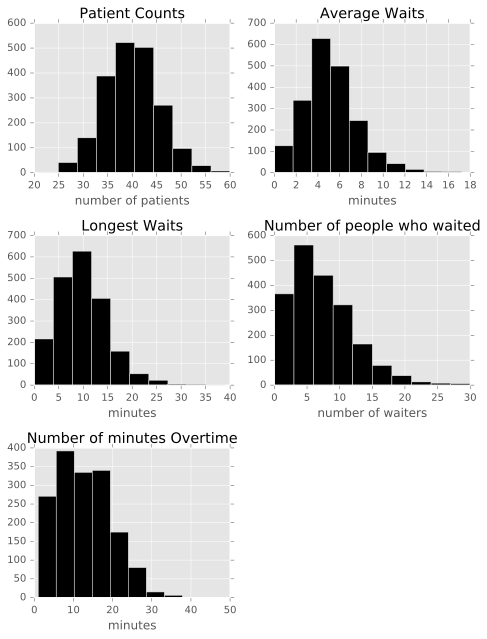

In [10]:
plt.rcParams['figure.figsize'] = 7, 9
plt.subplot(3, 2, 1)
plt.hist(patient_counts, color='black')
plt.xlabel('number of patients')
plt.title('Patient Counts')

plt.subplot(3, 2, 2)
plt.hist(avg_waits, color='black')
plt.xlabel('minutes')
plt.title('Average Waits')

plt.subplot(3, 2, 3)
plt.hist(longest_waits, color='black')
plt.xlabel('minutes')
plt.title('Longest Waits')

plt.subplot(3, 2, 4)
plt.hist(waiter_counts, color='black')
plt.xlabel('number of waiters')
plt.title('Number of people who waited')

plt.subplot(3, 2, 5)
plt.hist(overtimes, color='black')
plt.xlabel('minutes')
plt.title('Number of minutes Overtime')

plt.tight_layout();
# plt.savefig('stats_2.png', format='png', dpi=400)

# Posterior inference and predictive distributions.
1. Suppose you have a Beta(3, 3) prior distribution on the probability θ that a coin will yield ‘heads’ when spun in a specified manner. The coin is independently spun ten times, and ‘heads’ appear fewer than three times. You are not told how may heads were seen, only that the number is less than 3. Calculate your exact posterior density (up to a proportionality constant) for θ and sketch it.
<br><br><br>
2. Consider two coins, C1 and C2, with the following characteristics: Pr(heads|C1) = 0.4 and Pr(heads|C2) = 0.6. Choose one of the coins at random and imagine spinning it repeatedly.
    1. Given that the first two spins from the chosen coin are tails, what is the expected number of additional spins until a heads shows up?
    2. How about if the first three spins are all tails?

In [11]:
x = np.linspace(0, 1, 100)
prior = beta.pdf(x, 3, 3)
likelihood = binom.cdf(3, 10, x)
posterior = likelihood  * prior

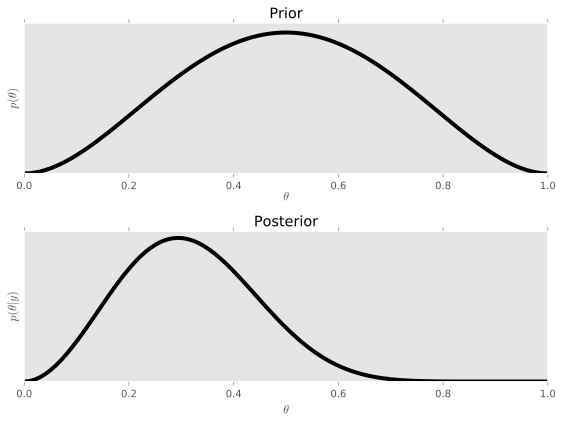

In [13]:
lw = 4
color = 'black'
plt.rcParams['figure.figsize'] = 8, 6
plt.style.use('ggplot')

plt.subplot(2, 1, 1)
plt.plot(x, prior, linewidth=lw, color=color)
plt.title('Prior')
plt.xlabel(r'$\theta$', labelpad=.01)
plt.ylabel(r'$p(\theta)$')
plt.yticks([])
plt.grid(b=False)

plt.subplot(2, 1, 2)
plt.plot(x, posterior, linewidth=lw, color=color)
plt.title('Posterior')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta|y)$')
plt.yticks([])
plt.grid(b=False)

plt.tight_layout();
plt.savefig('coin_flip_densities.png', format='png', dpi=400)

In [14]:
df = pd.read_csv('data/accident_data.csv', index_col='year')
df

,accidents,exposures
year,,
1976,24,3864
1977,25,4300
1978,31,5026
1979,31,5482
1980,22,5815
1981,21,6034
1982,26,5876
1983,20,6224
1984,16,7434


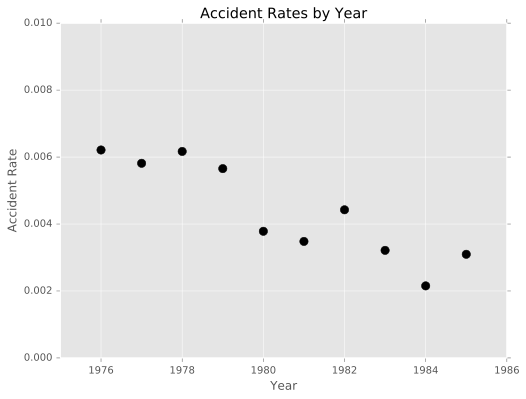

In [16]:
# check if the accident rate is increasing or decreasing
rates = df['accidents'] / df['exposures']
x = df.index.tolist()

# plot it
plt.scatter(x, rates, s=70, color='black')
plt.xlim([1975, 1986])
plt.ylim([0, 0.01])
plt.xlabel('Year')
plt.ylabel('Accident Rate')
plt.title('Accident Rates by Year')
plt.show();

# Multilevel Modeling

The following table gives the number of fatal accidents on scheduled airline flights, and exposure (in 100s of millions of passenger miles), per year, over a ten-year period.

- Assume that the numbers of fatal accidents in each year are independent with a Poisson(θ) distribution. Assign a $Gamma(\alpha,\beta)$ prior for $\theta$, selecting reasonable values for $\alpha$ and $\beta$.
    Using simulation, compute a 95% predictive interval for the number of fatal acci- dents in 1986.
    
- For t = 1,...,10, let yt denote the number of fatal accidents in year 1975 + t. Assume the yt are independent $Poisson(xt\theta)$, where xt denotes the exposure (in 100s of millions of passenger miles) in year 1975 + t. Assign a $Gamma(\alpha,\beta)$ prior for $\theta$; you will probably want different hyperparameter values than in part (1).
    Give a 95% predictive interval for the number of fatal accidents in 1986 under the assumption that 7.6 × 1011 passenger miles are flown that year.


$\theta$ ~ $Gamma(\alpha, \beta)$

$y_{i}$ ~ $Poisson(\theta)$

In [17]:
class BayesianPoissonModel:
    '''Spits out data simulated values from a bayesian model'''
    
    def __init__(self, initial_alpha, initial_beta, n_exposures=1):
        self.alpha = initial_alpha
        self.beta = initial_beta
        self.n_exposures = n_exposures
        
    
    def update(self, data):
        '''
        updates p(theta) to be p(theta|data)
        '''
        for y, n in data:
            self.alpha += y
            self.beta += n
    
    def simulate(self, n):
        theta = np.random.gamma(self.alpha, self.beta**-1, n)
        return np.random.poisson(theta * self.n_exposures)
    
    def __repr__(self):
        return '<model: alpha={:.2f}, beta={:.2f}>'.format(self.alpha, self.beta)
    
    def __str__(self):
        return self.__repr__()

We'll disregard number of exposures per year and only model the number of accidents

$\beta$ will be 1, as in a period of 1 year

<model: alpha=261.80, beta=11.00>
95% predictive interval: [14, 34]


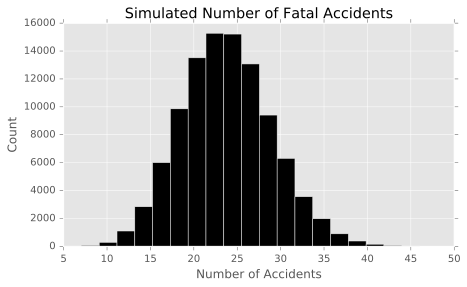

In [18]:
accidents_data = np.c_[df['accidents'].values, np.ones(df.shape[0])]

model = BayesianPoissonModel(df['accidents'].mean(), 1)
model.update(accidents_data)
simulated = model.simulate(n=100000)

print(model)
print('95% predictive interval: [{}, {}]'.format(*np.percentile(simulated, (2.5, 97.5)).astype(int)))

# plot it
plt.rcParams['figure.figsize'] = 7, 4
plt.hist(simulated, bins=20, color='black')
plt.xlabel('Number of Accidents')
plt.ylabel('Count')
plt.title('Simulated Number of Fatal Accidents')
plt.show();

Incorporate number of exposures into the models to "weight" each accident count appropriately

<model: alpha=261.80, beta=62877.10>
95% predictive interval: [21, 44]


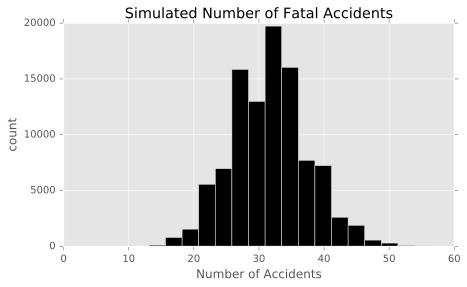

In [19]:
n_exposures = 7600
# use the means as a prior
a = df['accidents'].mean()
b = df['exposures'].mean()   

model_full = BayesianPoissonModel(a, b, n_exposures=n_exposures)
model_full.update(df[['accidents', 'exposures']].values)
simulated = model_full.simulate(n=100000)

print(model_full)
print('95% predictive interval: [{}, {}]'.format(*np.percentile(simulated, (2.5, 97.5)).astype(int)))

# plot it
plt.rcParams['figure.figsize'] = 7, 4
plt.hist(simulated, bins=20, color='black')
plt.xlabel('Number of Accidents')
plt.ylabel('count')
plt.title('Simulated Number of Fatal Accidents')
plt.show;

# Simulation

An experiment was performed to estimate the effect of beta blockers on mortality of cardiac patients. A group of patients were randomly assigned to treatment and control groups: out of 282 patients receiving the control, 37 died; out of 278 receiving the treatment, 25 died. Assume that the outcomes are independent and binomially distributed, with probabilities of death $p_0$ and $p_1$ under the control and treatment, respectively.

Set up a noninformative prior distribution on ($p_0$, $p_1$) and obtain posterior simulations. Summarize the posterior distribution for the <em>odds ratio</em>,


<center>$\rho$ = $\cfrac{\frac{p_1}{1 - p_1}}{\frac{p_0}{1 - p_0}}$</center>

95% predictive interval: [0.403, 1.113]


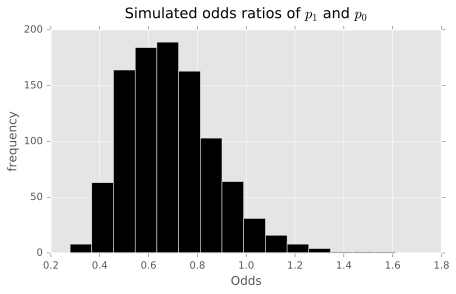

In [20]:
# draw 1000 p_0's and p_1's from their respective posteriors
n_samples = 1000
p_0 = np.random.beta(37 + 1, 282 - 37 + 1, n_samples)   # control
p_1 = np.random.beta(25 + 1, 278 - 25 + 1, n_samples)   # treatment

# compute each simulated odds ratio
odds_samples = (p_1 / (1 - p_1)) / (p_0 / (1 - p_0))

lower, upper = np.percentile(odds_samples, [2.5, 97.5])
print('95% predictive interval: [{:.3f}, {:.3f}]'.format(lower, upper))

# plot it
plt.hist(odds_samples, bins=15, color='black')
plt.xlabel('Odds')
plt.ylabel('frequency')
plt.title('Simulated odds ratios of $p_1$ and $p_0$', y=1.03)
# plt.savefig('p_7_plot.png', format='png', dpi=400)
plt.show()